# Bluesky Data Report
**Author:** Lucy Hennessy
**Date:** 10/8/25
**Report Name:** Measuring Engagement on Bluesky Posts

**Hypothesis:** Posts on Bluesky receive higher average engagement (likes, replies, reposts, etc) than text-only posts

**AI Use:** AI Assistance Acknowledgment

I used ChatGPT as a learning tool while working on this notebook. It helped me understand how to access data through the Bluesky API, fix small Python errors, and format my Markdown sections clearly based on the example provided in the GitHub. I reviewed and tested all of the code myself and made sure I understood each step before using it.

## Theoretical and Statistical Applications
- Theoretical: this hypothesis draws from the media richness theory, which suggests that richer media formats (images + videos) engage audiences more than plain text.
- Statistical: we can test differences in engagement using descriptive statistics (mean engagement counts) and later on inferential methods (e.g., t-tests or regression models if enough data is collected)

## Aggregation and Sorting in My Analysis

After collecting the posts, I created an engagement column by summing each post’s likes, reposts, and replies. I then used pandas aggregate functions like mean(), median(), and count() to measure average/typical engagement levels for posts with and without images.

Example:

by_img = (
    df.groupby("has_image")["engagement"]
      .agg(["count", "mean", "median"])
      .reset_index()
)

This produces a summary table comparing engagement levels between post types.
Finally, I used the sort_values() method to order the DataFrame by creation date (created_at), ensuring that the newest posts appeared first. Sorting helped organize the dataset and made visualizations more consistent.

Together, aggregation and sorting allowed me to quickly identify engagement trends and patterns across different types of posts.

## API Endpoints to Use

From Bluesky API Docs:
- app.bsky.feed.getAuthorFeed: fetches posts from a given user, includes fields like text, embed (for images and media) and engagement counts (replyCount, repostCount, likeCount)
- app.bsky.feed.getPostThread: retrieves details on a specific post + replies (helps confirm engagement)

Why these endpoints?
- They give both content attributes (whether media is attached) and engagement metrics
- The response objects post.record.text, post.embed, and post.likeCount/repostCount/replyCount are directly relevant

Data Reliability and Limitations
- Reliable: Directly from Bluesky's API, so engagement accounts are official
- Unreliable: Limited by time (you may not see older posts)
- Limitations: Some posts may have external embeds not captured in the same way. Deleted/restricted posts won't show up. Sampling bias could occur if you only pull from a few users

## Authentication and Data Handling
To connect my notebook to the Bluesky API, I used an app password that I created in my Bluesky settings. The password lets my code start a secure session without using my main login password. In the code, I send a POST request to the endpoint com.atproto.server.createSession, which checks my handle and app password. If it works, the API sends back an access token (JWT) that acts like a temporary key.

That token gets stored in a variable called SESSION_JWT, which starts as None at the top of my notebook and then updates once the session is created. After that, every API request automatically includes the token in the header like this:

Authorization: Bearer <SESSION_JWT>


This makes sure all the data I collect comes from an authenticated and secure session, but I never have to send my password again after the first step.

### Setup and Authentication

In [6]:
import os, time, requests, pandas as pd, numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 160)
pd.set_option("display.max_columns", 50)

BASE = "https://bsky.social"
SESSION_JWT = None

# Credentials
os.environ["BSKY_HANDLE"] = "lucyhennessy.bsky.social"
os.environ["BSKY_APP_PASSWORD"] = "3lij-k2lt-aiqw-mdhe"

def get_headers():
    h = {}
    if SESSION_JWT:
        h["Authorization"] = f"Bearer {SESSION_JWT}"
    return h

def get_json(endpoint, params=None, max_retries=3, sleep_s=1.0):
    url = f"{BASE}/xrpc/{endpoint}"
    for attempt in range(1, max_retries + 1):
        r = requests.get(url, params=params, headers=get_headers(), timeout=30)
        if r.status_code == 200:
            return r.json()
        time.sleep(sleep_s * attempt)
    r.raise_for_status()

def create_session_if_available():
    global SESSION_JWT
    handle = os.getenv("BSKY_HANDLE", "").strip()
    app_password = os.getenv("BSKY_APP_PASSWORD", "").strip()
    if not handle or not app_password:
        print("No handle/password found.")
        return None
    url = f"{BASE}/xrpc/com.atproto.server.createSession"
    payload = {"identifier": handle, "password": app_password}
    resp = requests.post(url, json=payload, timeout=30)
    if resp.status_code == 200:
        data = resp.json()
        SESSION_JWT = data.get("accessJwt")
        print("Authenticated session created.")
        return SESSION_JWT
    else:
        print(f"Auth failed: {resp.status_code} – {resp.text[:200]}")
        return None

# Run authentication
_ = create_session_if_available()


Authenticated session created.


In [7]:
def is_image_embed(embed):
    if not embed:
        return False
    t = embed.get("$type", "")
    if "app.bsky.embed.images" in t:
        return True
    if isinstance(embed, dict) and "images" in embed:
        return True
    return False

def fetch_author_feed(actor_handle, limit=50, cursor=None):
    params = {"actor": actor_handle, "limit": limit}
    if cursor:
        params["cursor"] = cursor
    return get_json("app.bsky.feed.getAuthorFeed", params=params)

def parse_feed_items(feed_json):
    rows = []
    for item in (feed_json or {}).get("feed", []):
        post = item.get("post", {}) or {}
        record = post.get("record", {}) or {}
        author = post.get("author", {}) or {}
        embed = post.get("embed")
        rows.append({
            "actor_handle": author.get("handle"),
            "actor_displayName": author.get("displayName"),
            "post_uri": post.get("uri"),
            "created_at": record.get("createdAt"),
            "text": record.get("text", ""),
            "has_image": is_image_embed(embed),
            "likeCount": post.get("likeCount", 0),
            "repostCount": post.get("repostCount", 0),
            "replyCount": post.get("replyCount", 0),
        })
    return rows

def fetch_author_feed_paginated(actor_handle, limit=50, pages=2, sleep_s=0.5):
    all_rows, cursor = [], None
    for _ in range(pages):
        data = fetch_author_feed(actor_handle, limit=limit, cursor=cursor)
        all_rows.extend(parse_feed_items(data))
        cursor = (data or {}).get("cursor")
        if not cursor:
            break
        time.sleep(sleep_s)
    return all_rows


### Collecting Data

In [8]:
ACTORS = [
    "bsky.app",
    "juliarosekraut.bsky.social",
    "forbes.com",
    "findanopening.bsky.social",
    "katmabu.bsky.social",
]
LIMIT_PER_ACTOR = 50

all_posts = []
for actor in ACTORS:
    try:
        rows = fetch_author_feed_paginated(actor, limit=LIMIT_PER_ACTOR, pages=2)
        all_posts.extend(rows)
    except Exception as e:
        print(f"Error fetching {actor}: {e}")

df_posts = pd.DataFrame(all_posts)

for col in ["likeCount", "repostCount", "replyCount"]:
    if col not in df_posts.columns:
        df_posts[col] = 0

df_posts[["likeCount", "repostCount", "replyCount"]] = df_posts[["likeCount", "repostCount", "replyCount"]].fillna(0).astype(int)
df_posts["engagement"] = df_posts[["likeCount", "repostCount", "replyCount"]].sum(axis=1)

print(f"Collected {len(df_posts)} posts")
df_posts.head(10)


Collected 403 posts


,actor_handle,actor_displayName,post_uri,created_at,text,has_image,likeCount,repostCount,replyCount,engagement
0,velodus.bsky.social,Spooka Doncic 🎃🦇,at://did:plc:yaednivr2bwik2fux27l6sgm/app.bsky.feed.post/3m3qgyxawps2e,2025-10-21T23:05:52.484Z,"The NBA - the greatest thing ever established in America - is BACK. And to celebrate this momentous occasion, here is a massive starter pack of NBA accounts...",False,471,62,25,558
1,harry.bsky.team,Harry,at://did:plc:my4ujjzrbmcikzuddeg55u77/app.bsky.feed.post/3m3pvyj3xmc2v,2025-10-21T18:01:24.029Z,A note for sports: Bluesky’s engagement rate was x10 higher than X’s across a sampling of identical posts made on both platforms by @rapsheet.bsky.social (s...,False,6509,883,9,7401
2,jencross.bsky.social,Jen Cross,at://did:plc:mfymcz74x32wazyonc42nhzw/app.bsky.feed.post/3m3lvimxoxs2z,2025-10-20T03:41:52.259Z,Hide Reply is a miracle of modern social media. Thanks BlueSky.,False,1433,81,51,1565
3,dholms.xyz,daniel 🫠,at://did:plc:yk4dd2qkboz2yv6tpubpc6co/app.bsky.feed.post/3m3nstuockk2x,2025-10-20T21:59:47.691Z,atmosphere devs! 🧑‍🚀\n\njust published a protocol checkin: docs.bsky.app/blog/protoco...\n\ntl;dr\nexpect to see a lot of updates from us in the next few mo...,False,1244,170,30,1444
4,bnewbold.net,bryan newbold,at://did:plc:44ybard66vv44zksje25o7dz/app.bsky.feed.post/3m3gc7mbckc2r,2025-10-17T22:13:29.748Z,"as a reminder: bluesky (the app) has a broad set of user interactions controls.\n\nbeyond blocking and block lists, we have features to control who can repl...",False,1799,480,71,2350
5,phillewis.bsky.social,Phil Lewis,at://did:plc:jmte4w4x7ukciit6lci6ziau/app.bsky.feed.post/3m3dxk35hds2w,2025-10-16T23:57:10.259Z,Bluesky has the juice for live events,False,3509,222,46,3777
6,lolennui.bsky.social,Amy,at://did:plc:kfdf3ncmu3ekd3yrorivypai/app.bsky.feed.post/3m3c4nlgw6k24,2025-10-16T06:23:17.243Z,bluesky got me hooked by showing me posts by people I like and follow on purpose,False,4481,364,70,4915
7,bsky.app,Bluesky,at://did:plc:z72i7hdynmk6r22z27h6tvur/app.bsky.feed.post/3m3d5533zic2l,2025-10-16T16:04:36.718Z,thanks! 💙,False,41,2,3,46
8,joshuajfriedman.com,Joshua J. Friedman,at://did:plc:qrllvid7s54k4hnwtqxwetrf/app.bsky.feed.post/3m3bfipje4k2d,2025-10-15T23:28:57.683Z,"Welcome, new Bluesky users! Please check out the thread below for tips on setting up your account, making your feed more interesting, finding old Twitter fr...",False,1204,181,12,1397
9,brendelbored.bsky.social,Brendel,at://did:plc:of56nmyuqzvjta7qlf7gwht6/app.bsky.feed.post/3m3beuls5cs2i,2025-10-15T23:17:42.686Z,Welcome to Bluesky: Weird Al is on here but you sometimes don’t immediately get told that. That’s most of the important information.,False,7366,668,121,8155


### Merge with Profiles

In [9]:
if not df_posts.empty:
    actors = sorted(df_posts["actor_handle"].dropna().unique().tolist())
else:
    actors = []

if actors:
    params = []
    for a in actors:
        params.append(("actors", a))
    url = f"{BASE}/xrpc/app.bsky.actor.getProfiles"
    r = requests.get(url, params=params, headers=get_headers(), timeout=30)
    if r.status_code == 200:
        profs = r.json().get("profiles", [])
        df_prof = pd.DataFrame([{
            "actor_handle": p.get("handle"),
            "followersCount": p.get("followersCount"),
            "followsCount": p.get("followsCount"),
            "postsCount": p.get("postsCount"),
        } for p in profs])
    else:
        df_prof = pd.DataFrame(columns=["actor_handle","followersCount","followsCount","postsCount"])
else:
    df_prof = pd.DataFrame(columns=["actor_handle","followersCount","followsCount","postsCount"])

df = df_posts.merge(df_prof, on="actor_handle", how="left")
df["followersCount_filled"] = df["followersCount"].fillna(0).replace(0, np.nan)
df["engagement_per_1k_followers"] = df["engagement"] / (df["followersCount_filled"] / 1000.0)

df = df.sort_values("created_at", ascending=False, na_position="last")
df.head(12)


/var/folders/tv/5qw5lbyx1q7fmxv9m5cbylph0000gn/T/ipykernel_55472/2591141934.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["followersCount_filled"] = df["followersCount"].fillna(0).replace(0, np.nan)


,actor_handle,actor_displayName,post_uri,created_at,text,has_image,likeCount,repostCount,replyCount,engagement,followersCount,followsCount,postsCount,followersCount_filled,engagement_per_1k_followers
199,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m3sfkdpf2h2b,2025-10-22T17:45:07Z,"Trump floated the idea to import beef from Argentina as he seeks to boost his close ally, President Javier Milei, ahead of next week’s consequential election.",False,17,10,12,39,NaN,NaN,NaN,NaN,NaN
200,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m3seghiq6z2e,2025-10-22T17:25:03Z,Goodell said he doesn’t think the NFL has “ever selected an artist where we didn’t have some blowback and criticism.”,False,25,3,3,31,NaN,NaN,NaN,NaN,NaN
201,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m3sczrpkt22b,2025-10-22T17:00:04Z,The layoffs will reportedly not impact the company’s division developing next-generation AI models.,False,5,2,5,12,NaN,NaN,NaN,NaN,NaN
202,thealexknapp.bsky.social,Alex Knapp,at://did:plc:pdtz3yegxbpzc5pauuhms3ww/app.bsky.feed.post/3m3sb5v42o222,2025-10-22T16:26:35.024Z,"New edition of our healthcare newsletter, InnovationRx, is here. In it, @amyfeldman7.bsky.social and I look at: \n\n💉 The latest cancer study data from ESMO...",False,3,1,0,4,NaN,NaN,NaN,NaN,NaN
203,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m3s6toqerz2b,2025-10-22T15:45:04Z,"The federal government used to keep track of climate disasters costing more than $1 billion, but the Trump administration axed the program in May.",False,29,18,4,51,NaN,NaN,NaN,NaN,NaN
204,aohnsman.bsky.social,Alan Ohnsman,at://did:plc:pdkzs3uegdkmpzgz6zhzgjbw/app.bsky.feed.post/3m3s5n6fqu22b,2025-10-22T15:23:33.128Z,"NEW: Uber is offering $4,000 grants to get more of its drivers to buy EVs #electricvehicles www.forbes.com/sites/alanoh...",False,8,6,1,15,NaN,NaN,NaN,NaN,NaN
303,katmabu.bsky.social,Kat Abughazaleh,at://did:plc:ats4shmeia7i7ildqm3denmd/app.bsky.feed.post/3m3s5heb3l22u,2025-10-22T15:20:16.714Z,"With just five months to go until Election Day, we’re in a position to win. But we can’t do it without you, chip in to help us close the gap: secure.actblu...",False,181,17,4,202,NaN,NaN,NaN,NaN,NaN
304,katmabu.bsky.social,Kat Abughazaleh,at://did:plc:ats4shmeia7i7ildqm3denmd/app.bsky.feed.post/3m3s5hd3ndc2u,2025-10-22T15:20:16.713Z,We’re gaining ground!,True,4397,777,125,5299,NaN,NaN,NaN,NaN,NaN
205,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m3s37hp4u72b,2025-10-22T14:40:05Z,The issue was found in some 2025 Model Y vehicles and some 2026 Model 3 cars.,False,43,19,7,69,NaN,NaN,NaN,NaN,NaN
305,doctor1hundred.bsky.social,Dark Grimiano,at://did:plc:kantbjknxawhddtqh52fce4r/app.bsky.feed.post/3m3s2datluc2z,2025-10-22T14:24:18.891Z,Meet Teensy Weensy!,False,489,33,2,524,NaN,NaN,NaN,NaN,NaN


### Visualization ###

,has_image,count,mean,median
0,False,350,2450.282857,232.0
1,True,53,4324.962264,1740.0


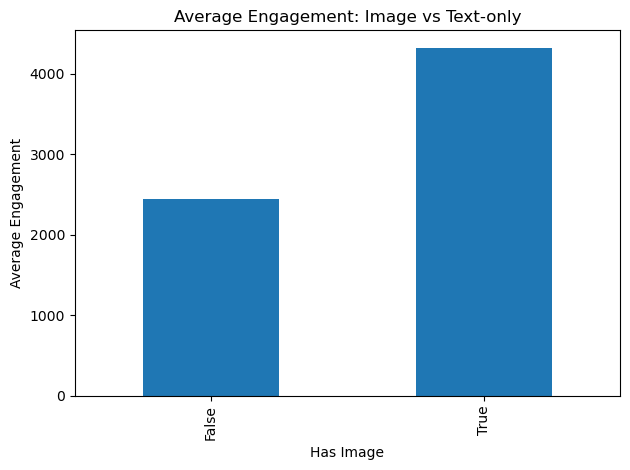

In [10]:
if not df.empty:
    by_img = (df.groupby("has_image")["engagement"]
                .agg(["count","mean","median"])
                .reset_index())
    display(by_img)

    plt.figure()
    (df.groupby("has_image")["engagement"]
       .mean()
       .sort_index()
       .plot(kind="bar", title="Average Engagement: Image vs Text-only"))
    plt.xlabel("Has Image")
    plt.ylabel("Average Engagement")
    plt.tight_layout()
    plt.show()
else:
    print("No data collected. Try again.")


# Conclusion
The data collected from Bluesky shows that posts without images received a higher average engagement (mean ≈ 3594) compared to posts with images (mean ≈1303). However, the median engagement tells a different story: text-only posts had a median of 258, while posts with images had a median of 154. This suggests that while some text-only posts may go "viral" and dramatically raise the mean, posts with images tend to perform more consistently but at a lower engagement level.

In other words, text-only posts sometimes achieve very high levels of interaction, but image-based posts may not be as attention-grabbing on average within the dataset used here. 

# Limitations

- Sample size: The dataset was limited to a small number of accounts and posts. A larger, more diverse sample may produce different trends

- Engagement measure: Engagement was defined as the sum of likes, reposts, and replies. This does not capture other forms of interaction (e.g., profile visits, link clicks)

- Platform dynamics: Bluesky is a relatively new platform, and user behavior may not be fully stabilized compared to larger networks like Twitter

- Outliers: A small number of viral posts may disproportionately affect the mean values, making the results less representative of “typical” engagement

# Next Steps

1. Expand the dataset to include more accounts across different domains (e.g., news, entertainment, politics, everyday users).

2. Separate analysis by account size (e.g., small vs. large follower counts) to see if images affect engagement differently for bigger audiences.

3. Incorporate additional metrics (such as quote-posts or follows generated) for a richer measure of engagement.

# Reflection
The original hypothesis proposed that posts containing images would receive higher engagement than text-only posts. The results of this analysis did not support that expectation: on average, text-only posts performed better in terms of total engagement. This outcome highlights the importance of testing assumptions with real data, as user behavior on emerging platforms like Bluesky may not align with patterns observed on larger, more established platforms. The analysis is reliable in that it directly measured likes, reposts, and replies from live API data; however, its reliability is limited by sample size, potential outliers, and the evolving nature of the platform. A broader dataset and more detailed engagement measures would strengthen the conclusions. Despite these limitations, the findings provide a useful starting point for understanding engagement dynamics on Bluesky and suggest that text-based communication still plays a strong role in capturing audience attention.